In [1]:
#################################################################################################
# Import necessary libraries
#################################################################################################
import numpy as np
import pandas as pd
from xgboost import XGBRegressor
from ngboost.api import NGBRegressor
from ngboost.distns import Normal
from ngboost.scores import MLE
from ngboost.learners import DecisionTreeRegressor
from ngboost.evaluation import *
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.feature_selection import RFECV
from sklearn.metrics import mean_squared_error, r2_score, make_scorer
from time import time
from pprint import pprint
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
from scipy import stats
from scipy.stats import norm, skew

In [2]:
Data_DF = pd.read_excel('Construction_Estimation_Data_One_Way_New.xlsx')
Data_DF.dropna(inplace=True)

In [3]:
Feature_Names = ['X1', 'X2', 'X3', 'X4', 'X5','X6', 'X7', 'X8', 'X9', 'X10']

X = Data_DF[Feature_Names].to_numpy()
y = Data_DF['Y'].to_numpy()

In [4]:
df1 = Data_DF.describe()
df1.to_excel("Descriptive Statistics 1 Way.xlsx")

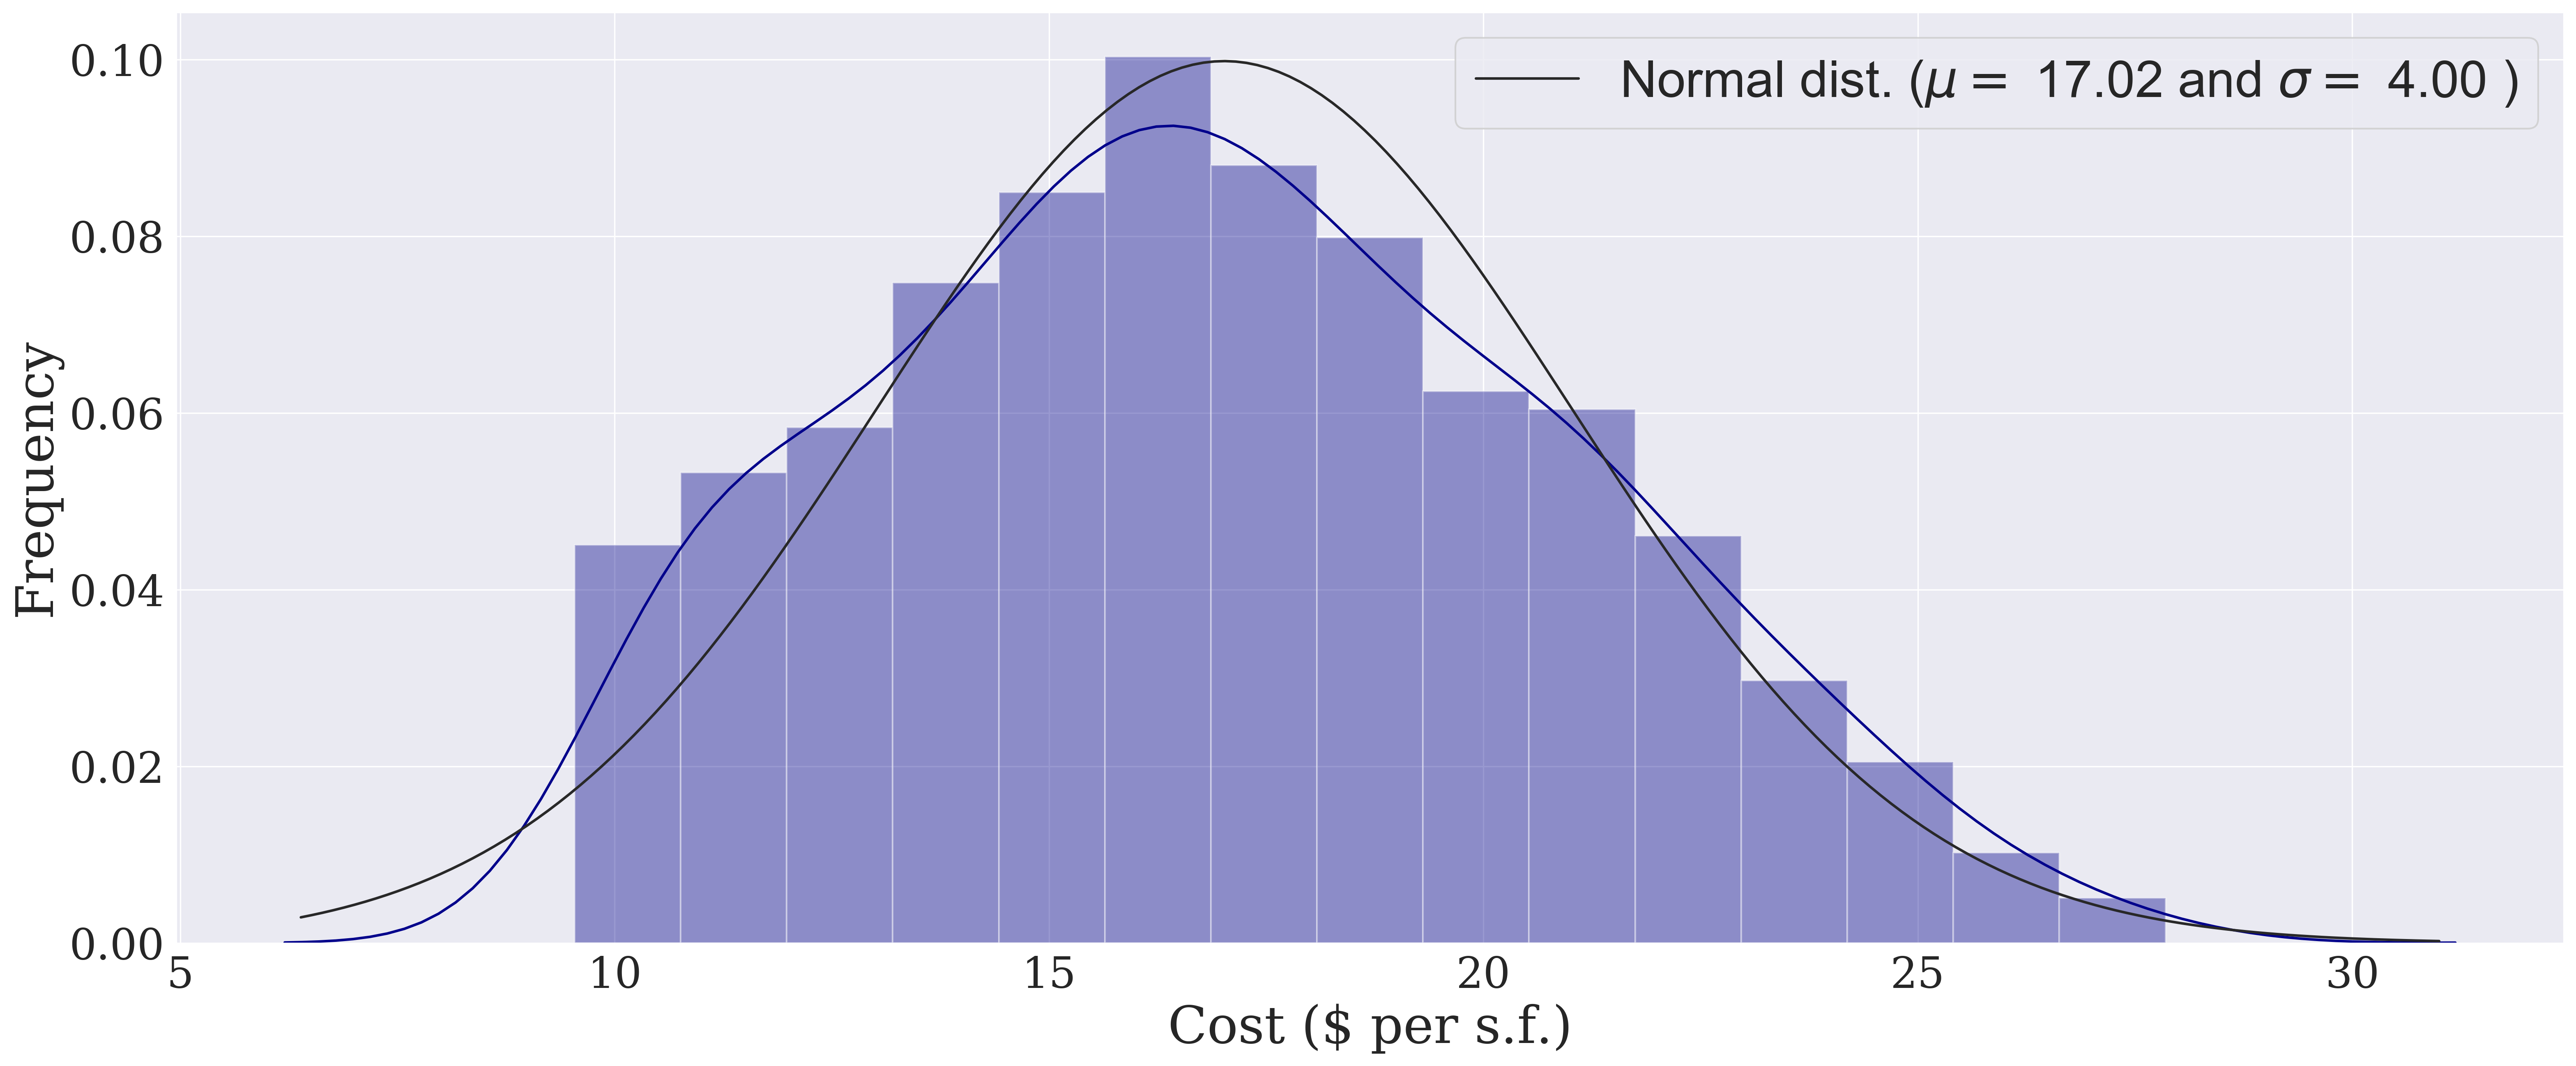

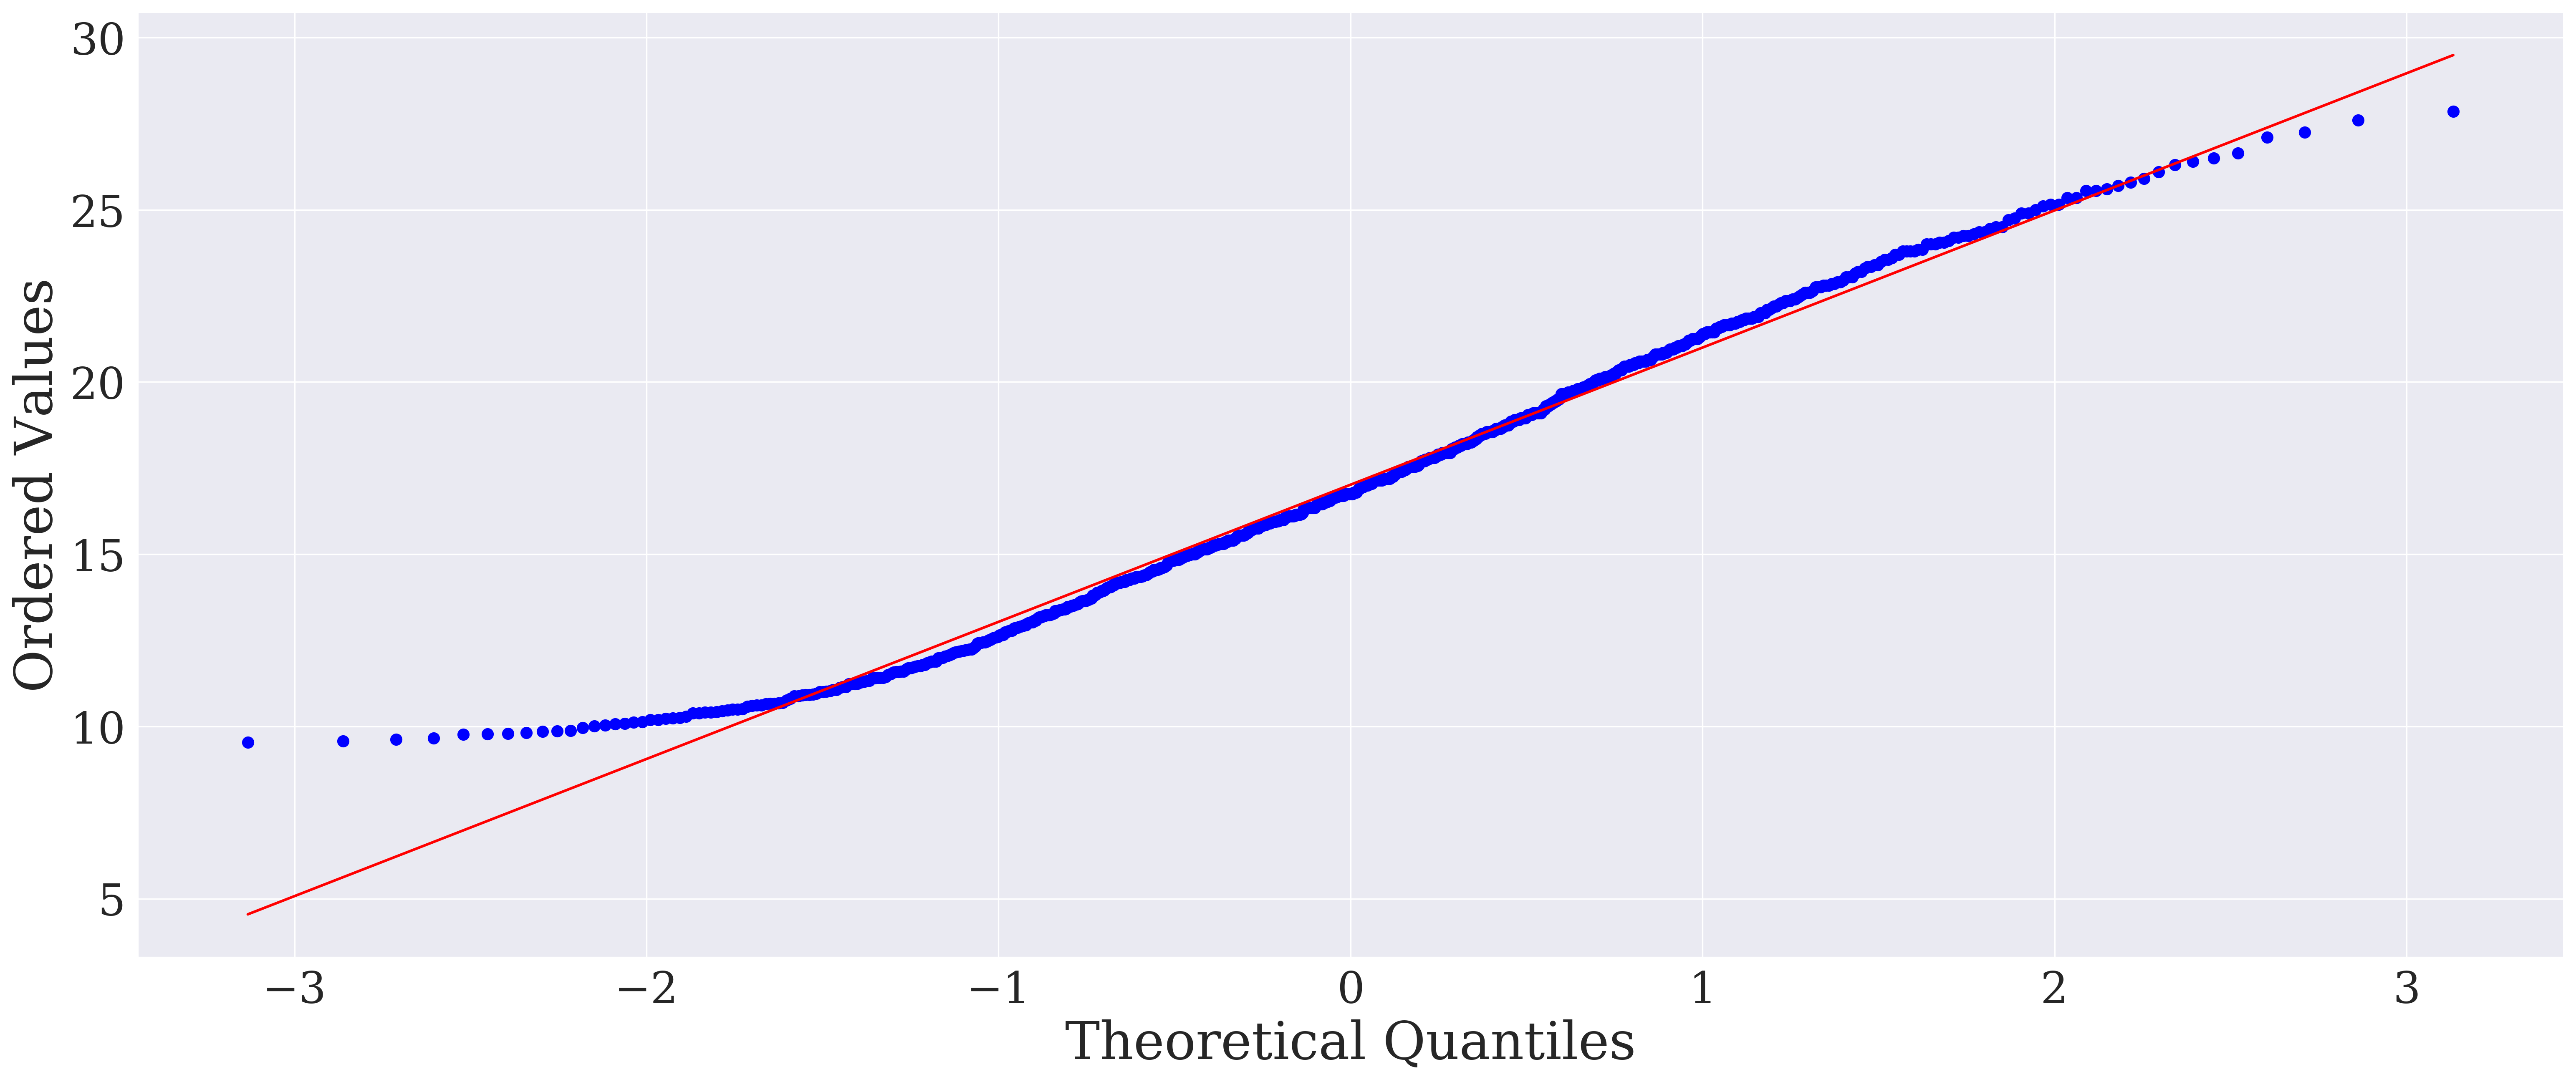

In [5]:
fig = plt.figure(figsize=(25,10),dpi=300)
sns.distplot(Data_DF['Y'], fit = norm, color='darkblue')
(mu, sigma) = norm.fit(Data_DF['Y'])
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)], loc='best', fontsize=30)
plt.xlabel('Cost ($ per s.f.)', fontsize=30, fontname='Serif')
plt.ylabel('Frequency', fontsize=30, fontname='Serif')
plt.xticks(fontsize=25, fontname='Serif')
plt.yticks(fontsize=25, fontname='Serif')
plt.figaspect(1.)
plt.title('')
plt.savefig('Assembly Cost Distribution 1 Way 1.pdf')

fig = plt.figure(figsize=(25,10),dpi=300)
res = stats.probplot(Data_DF['Y'], plot=plt)
plt.xlabel('Theoretical Quantiles', fontsize=30, fontname='Serif')
plt.ylabel('Ordered Values', fontsize=30, fontname='Serif')
plt.xticks(fontsize=25, fontname='Serif')
plt.yticks(fontsize=25, fontname='Serif')
plt.figaspect(1.)
plt.title('')
plt.show
plt.savefig('Assembly Cost Distribution 1 Way 2.pdf')

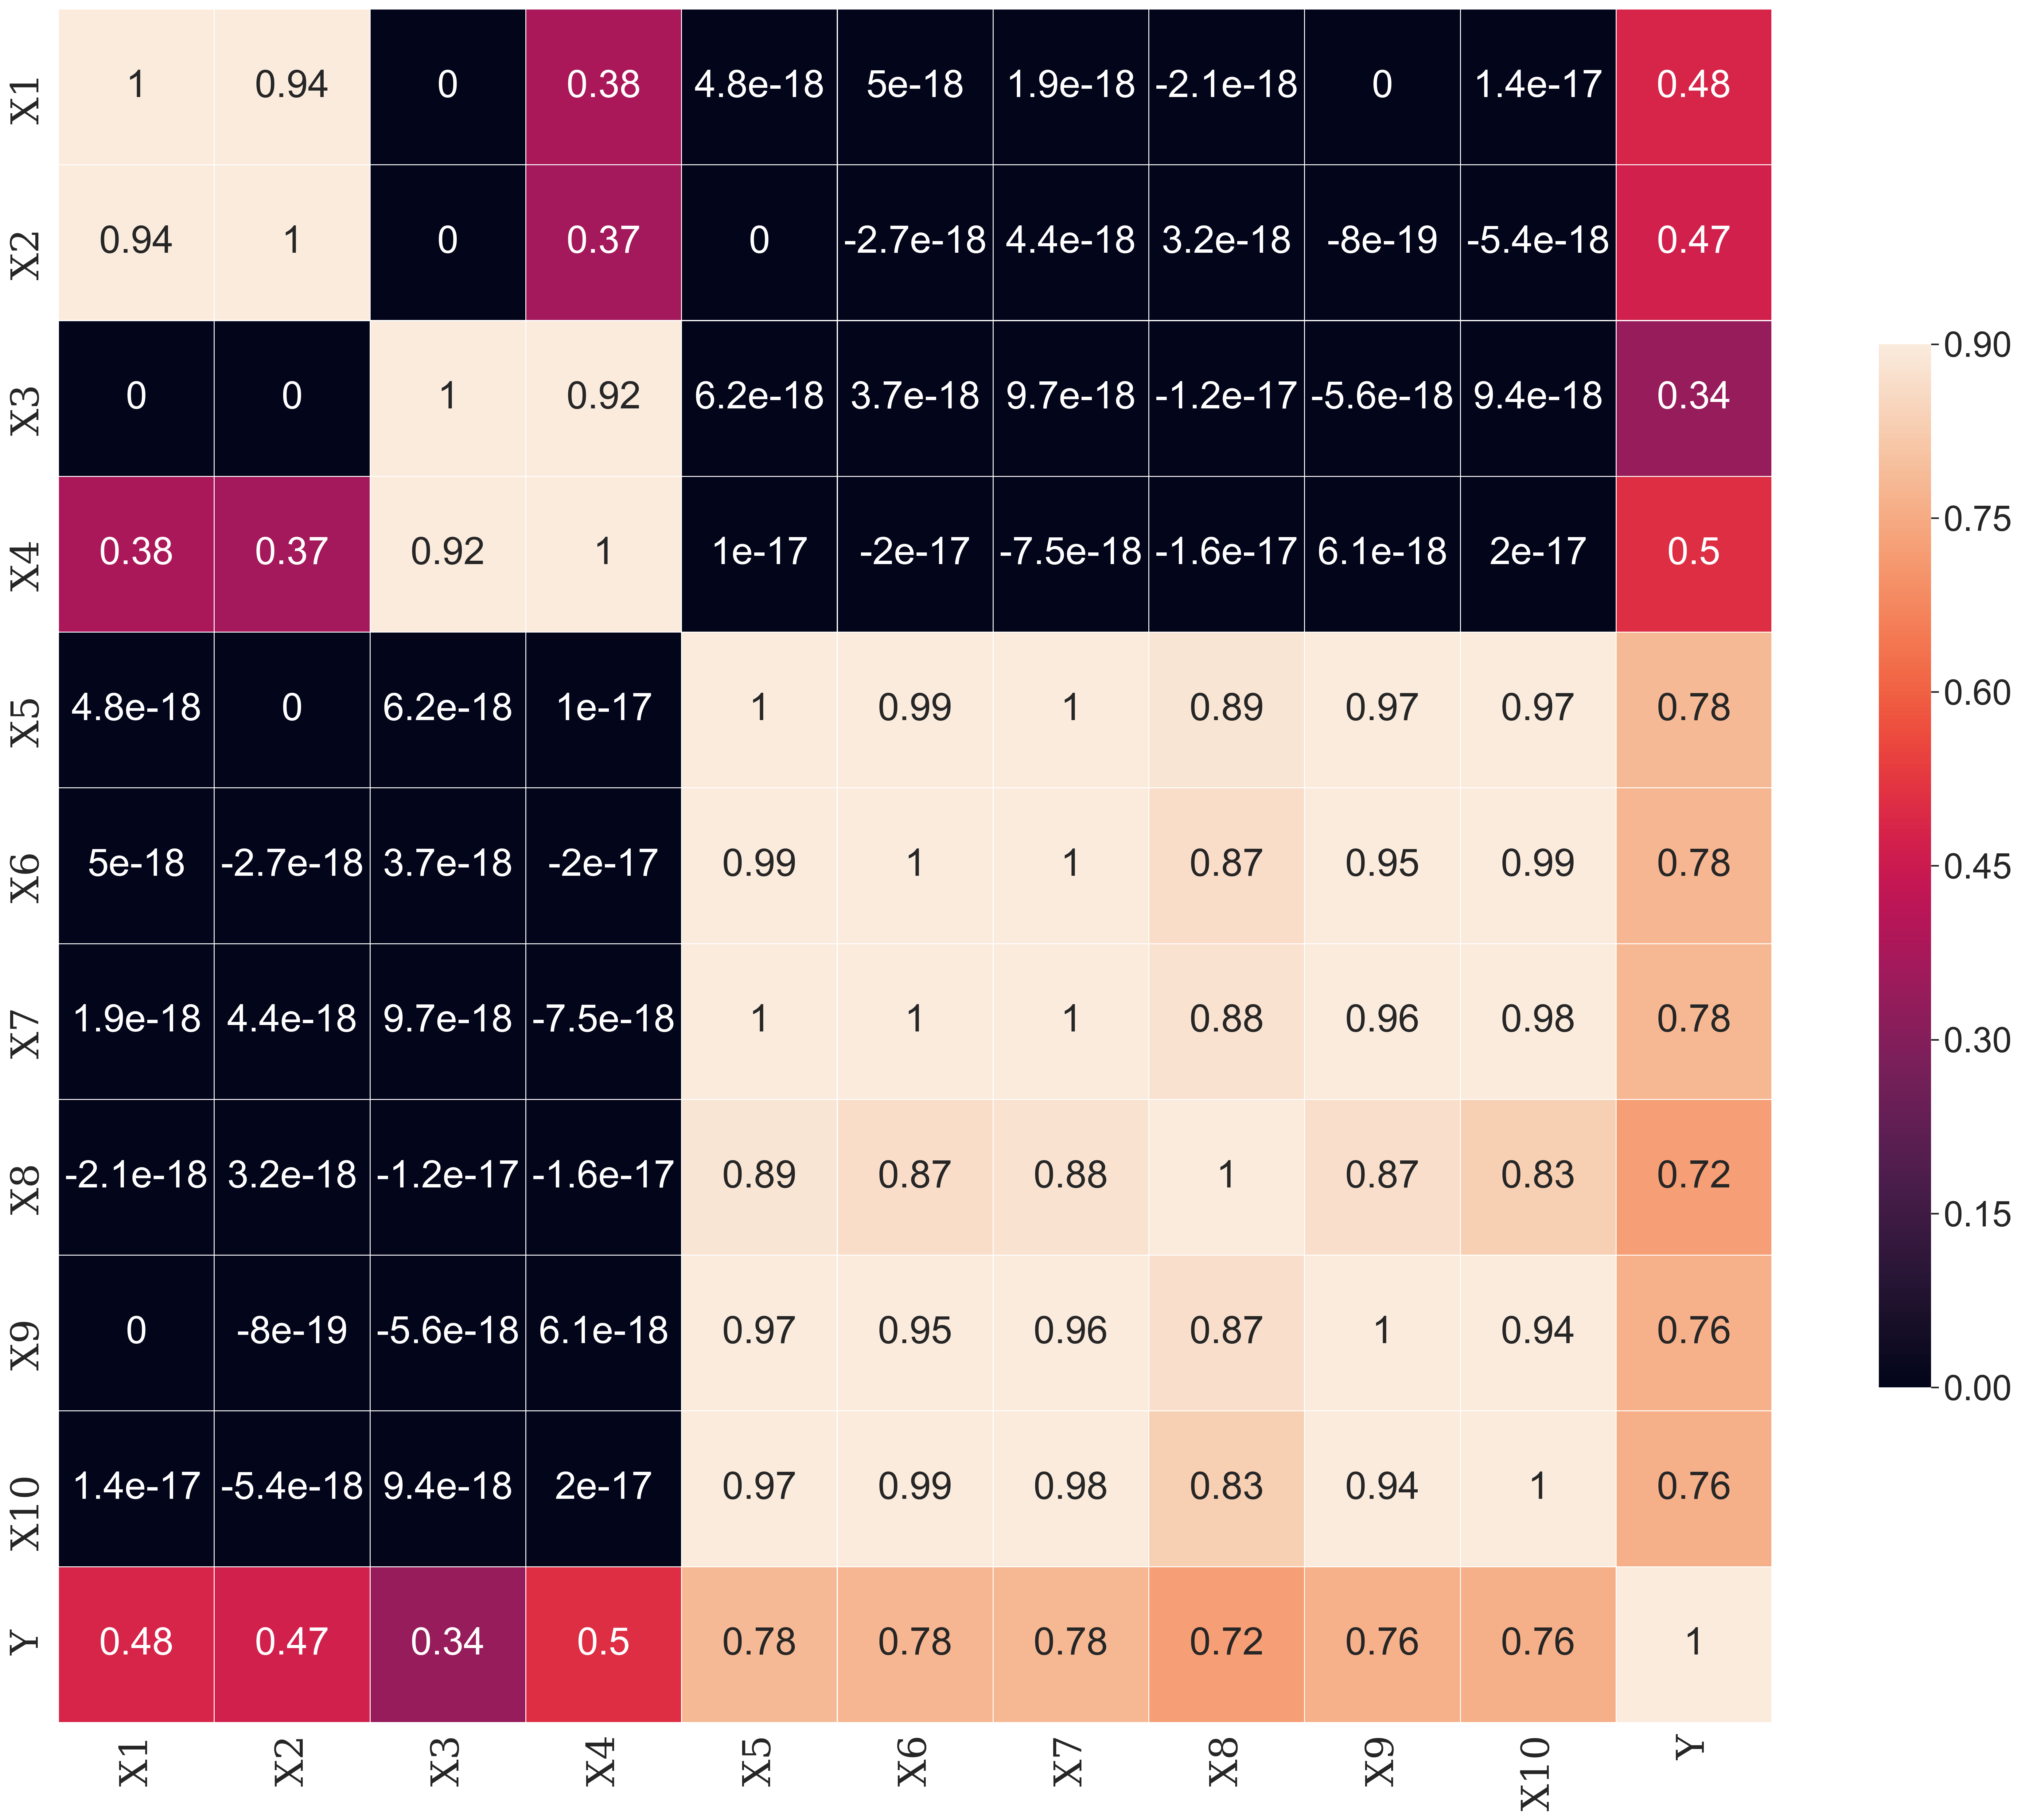

In [6]:
corr_mat = Data_DF.corr()
fig = plt.figure(figsize=(30,30),dpi=300)
sns.set(font_scale=2.5)
sns.heatmap(corr_mat, vmax=0.9, square=True, linewidths=.5, annot=True, annot_kws={"size": 30}, cbar_kws={"shrink": .5})
plt.xticks(fontsize=30, fontname='Serif', rotation=90)
plt.yticks(fontsize=30, fontname='Serif')
plt.figaspect(1.)
plt.title('')
plt.savefig('Correlation Heatmap 1 Way.pdf')

In [7]:
#################################################################################################
# To test the model
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, shuffle=True, random_state=7)
#################################################################################################

In [8]:
#################################################################################################
# Pipeline for feature selection, hyper-parameter optimization, and model generation
#################################################################################################
ngb = NGBRegressor(Dist=Normal, Score=MLE, Base=XGBRegressor(),n_estimators=500, 
                   learning_rate=0.005)
ngb.fit(X_train, y_train)

C:\Users\wlv446\xgboost\python-package\xgboost\core.py:733: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


[iter 0] loss=2.7971 val_loss=0.0000 scale=1.0000 norm=3.3412
[iter 100] loss=2.2489 val_loss=0.0000 scale=2.0000 norm=3.4417
[iter 200] loss=1.7327 val_loss=0.0000 scale=2.0000 norm=1.6172
[iter 300] loss=1.2341 val_loss=0.0000 scale=2.0000 norm=1.1141
[iter 400] loss=0.7395 val_loss=0.0000 scale=2.0000 norm=1.0158


NGBRegressor(Base=XGBRegressor(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1, gamma=0,
                               importance_type='gain', learning_rate=0.1,
                               max_delta_step=0, max_depth=3,
                               min_child_weight=1, missing=None,
                               n_estimators=100, n_jobs=1, num_parallel_tree=1,
                               objective='reg:squarederror', random_state=0,
                               reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
                               subsample=1, tree_method='auto', verbosity=1),
             Dist=<class 'ngboost.distns.normal.Normal'>,
             Score=<class 'ngboost.scores.MLE'>, learning_rate=0.005,
             minibatch_frac=1.0, n_estimators=500, natural_gradient=True,
             tol=0.0001, verbose=True, verbose_eval=100)

In [9]:
#################################################################################################
# Make predictions on testing data and test model accuracy
#################################################################################################

Predicted_PET = ngb.pred_dist(X_test)

rmse = np.sqrt(mean_squared_error(y_test,Predicted_PET.dist.mean()))
RSQ = r2_score(y_test,Predicted_PET.dist.mean())
MAPE = np.mean(np.abs((y_test-Predicted_PET.dist.mean()) / y_test)) * 100
MAE = np.mean(np.abs(y_test-Predicted_PET.dist.mean()))
print("############ Model Accuracy ############")
print("RMSE: %0.3f" % rmse)
print("MAE: %0.3f" % MAE)
print("R-squared: %0.3f" % RSQ)
print("MAPE: %0.3f" % MAPE)
print("########################################")
print(" ")

############ Model Accuracy ############
RMSE: 0.104
MAE: 0.072
R-squared: 0.999
MAPE: 0.411
########################################
 


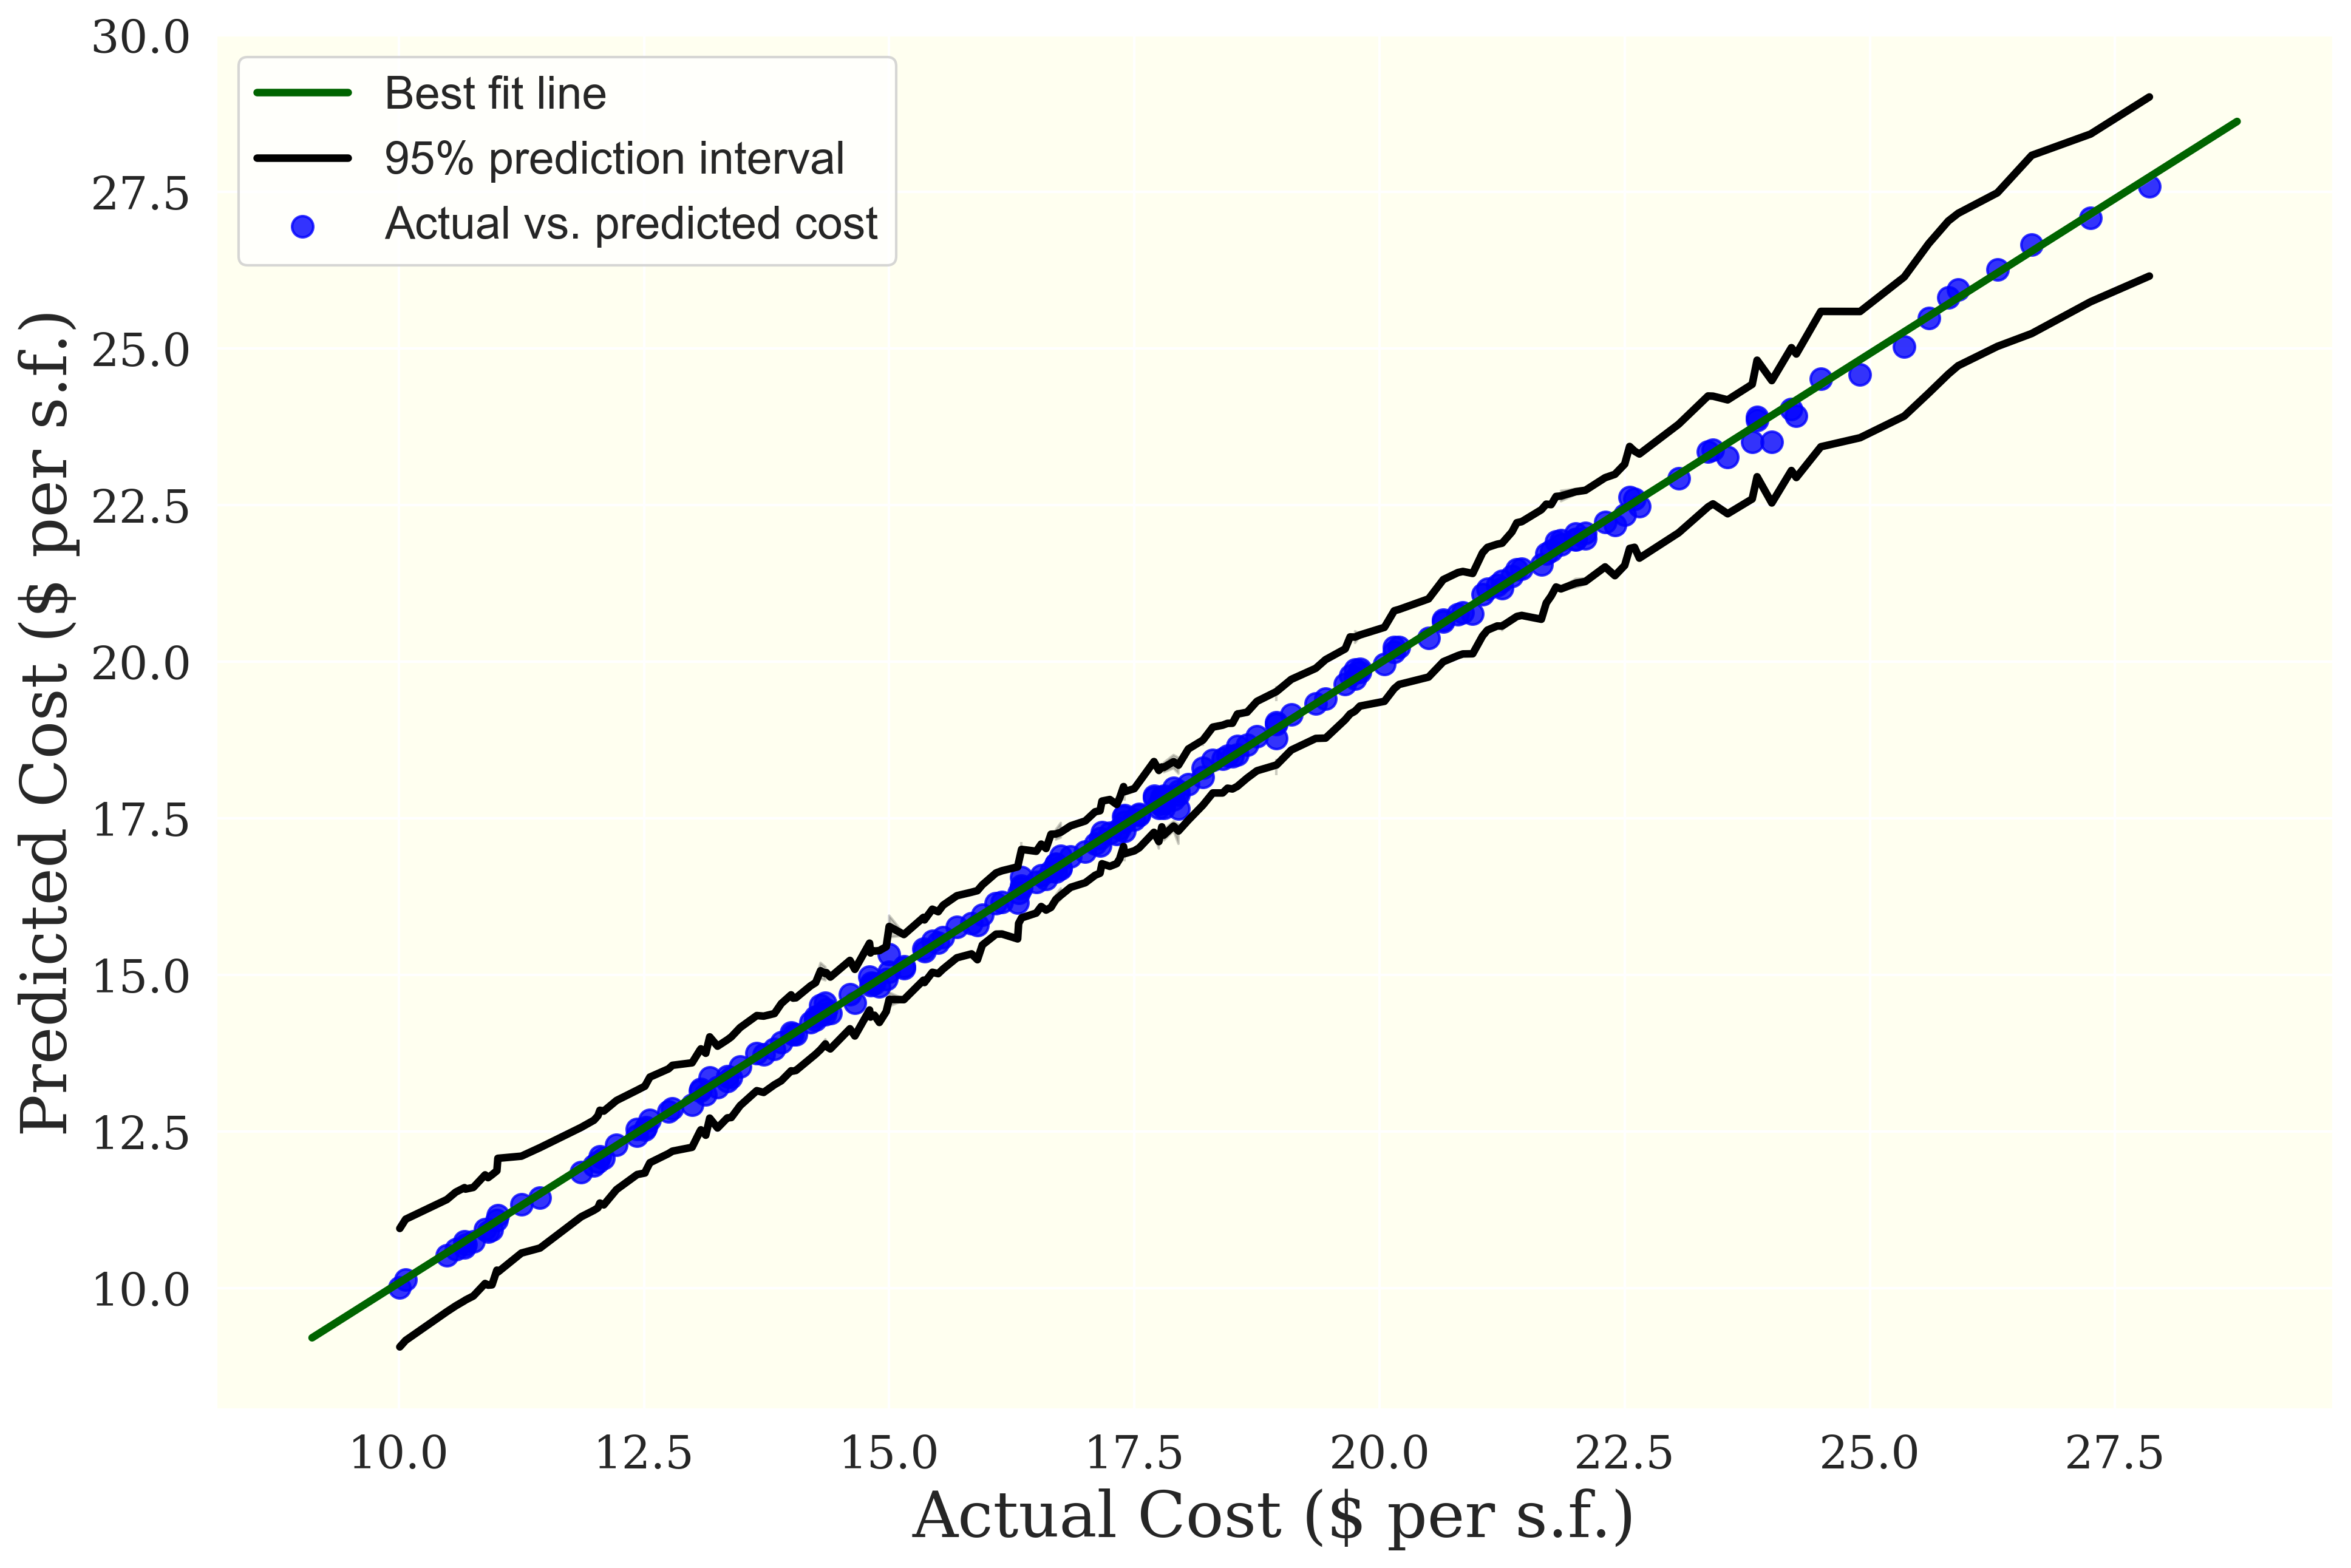

In [10]:
fig = plt.figure(figsize=(15,10),dpi=300)
ax = fig.add_subplot(1,1,1,facecolor='ivory')
sns.regplot(y_test, Predicted_PET.dist.mean(), x_ci='ci', label = 'Actual vs. predicted cost',
            scatter_kws={'color': 'blue', 's': 70},
            line_kws={'color': 'darkgreen', 'linewidth': 3, 'label': 'Best fit line'})
#sns.lineplot(y_test, Predicted_PET.dist.mean(), color = "darkgreen", linestyle = "-", linewidth=3, 
#             label = 'Predicted average unit cost ($)')
sns.lineplot(y_test, Predicted_PET.loc - 1.96 * Predicted_PET.scale, color = "black", linestyle = "--", linewidth=3)
sns.lineplot(y_test, Predicted_PET.loc + 1.96 * Predicted_PET.scale, color = "black", linestyle = "--", linewidth=3,
             label = '95% prediction interval')
plt.xlabel("Actual Cost ($ per s.f.)", fontsize=25, fontname='Serif')
plt.ylabel("Predicted Cost ($ per s.f.)", fontsize=25, fontname='Serif')
plt.xticks(fontsize=18, fontname='Serif')
plt.yticks(fontsize=18, fontname='Serif')
plt.figaspect(1.)
plt.legend(loc='upper left', prop={'size': 18}, facecolor='white')
plt.savefig('Scatter_Plot_1_Way_NGBoost.pdf')

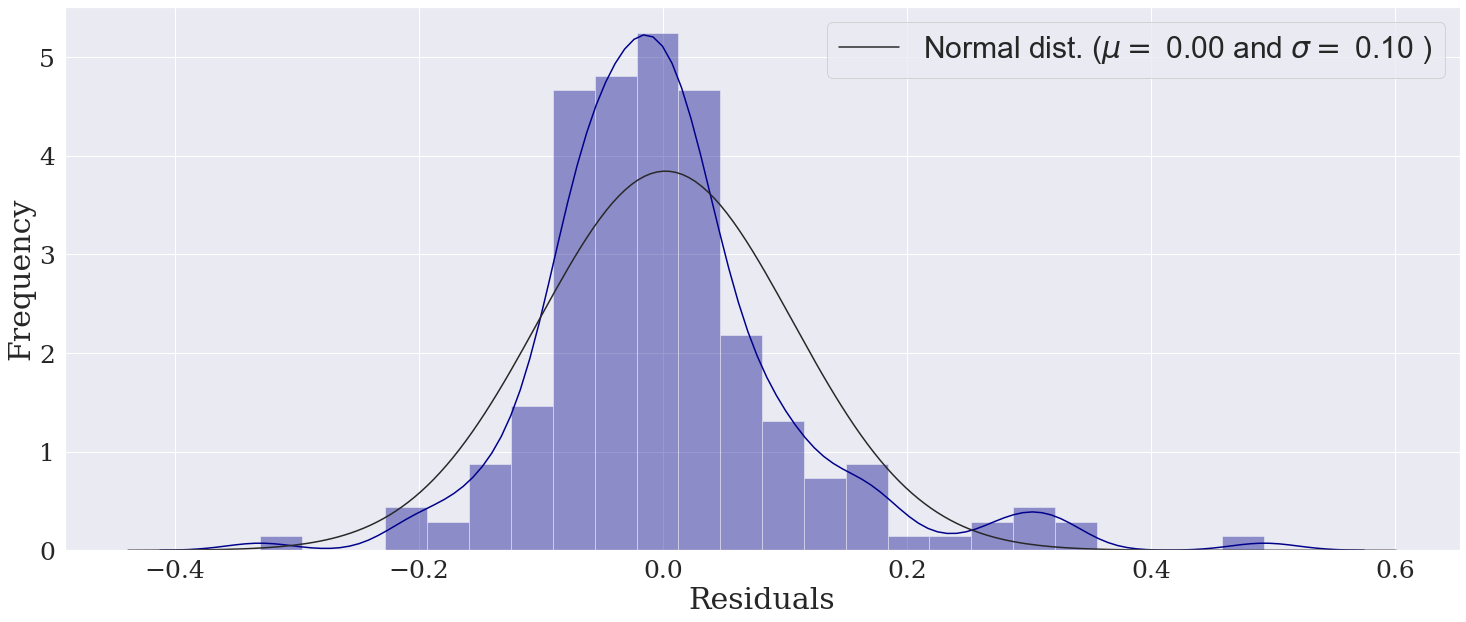

In [11]:
residuals = (y_test-Predicted_PET.dist.mean())
fig = plt.figure(figsize=(25,10),dpi=72)
sns.distplot(residuals, fit = norm, color='darkblue')
(mu, sigma) = norm.fit(residuals)
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)], loc='best', fontsize=30)
plt.xlabel('Residuals', fontsize=30, fontname='Serif')
plt.ylabel('Frequency', fontsize=30, fontname='Serif')
plt.xticks(fontsize=25, fontname='Serif')
plt.yticks(fontsize=25, fontname='Serif')
plt.figaspect(1.)
plt.title('')
plt.savefig('Residual Distribution 1 Way NGBoost.pdf')

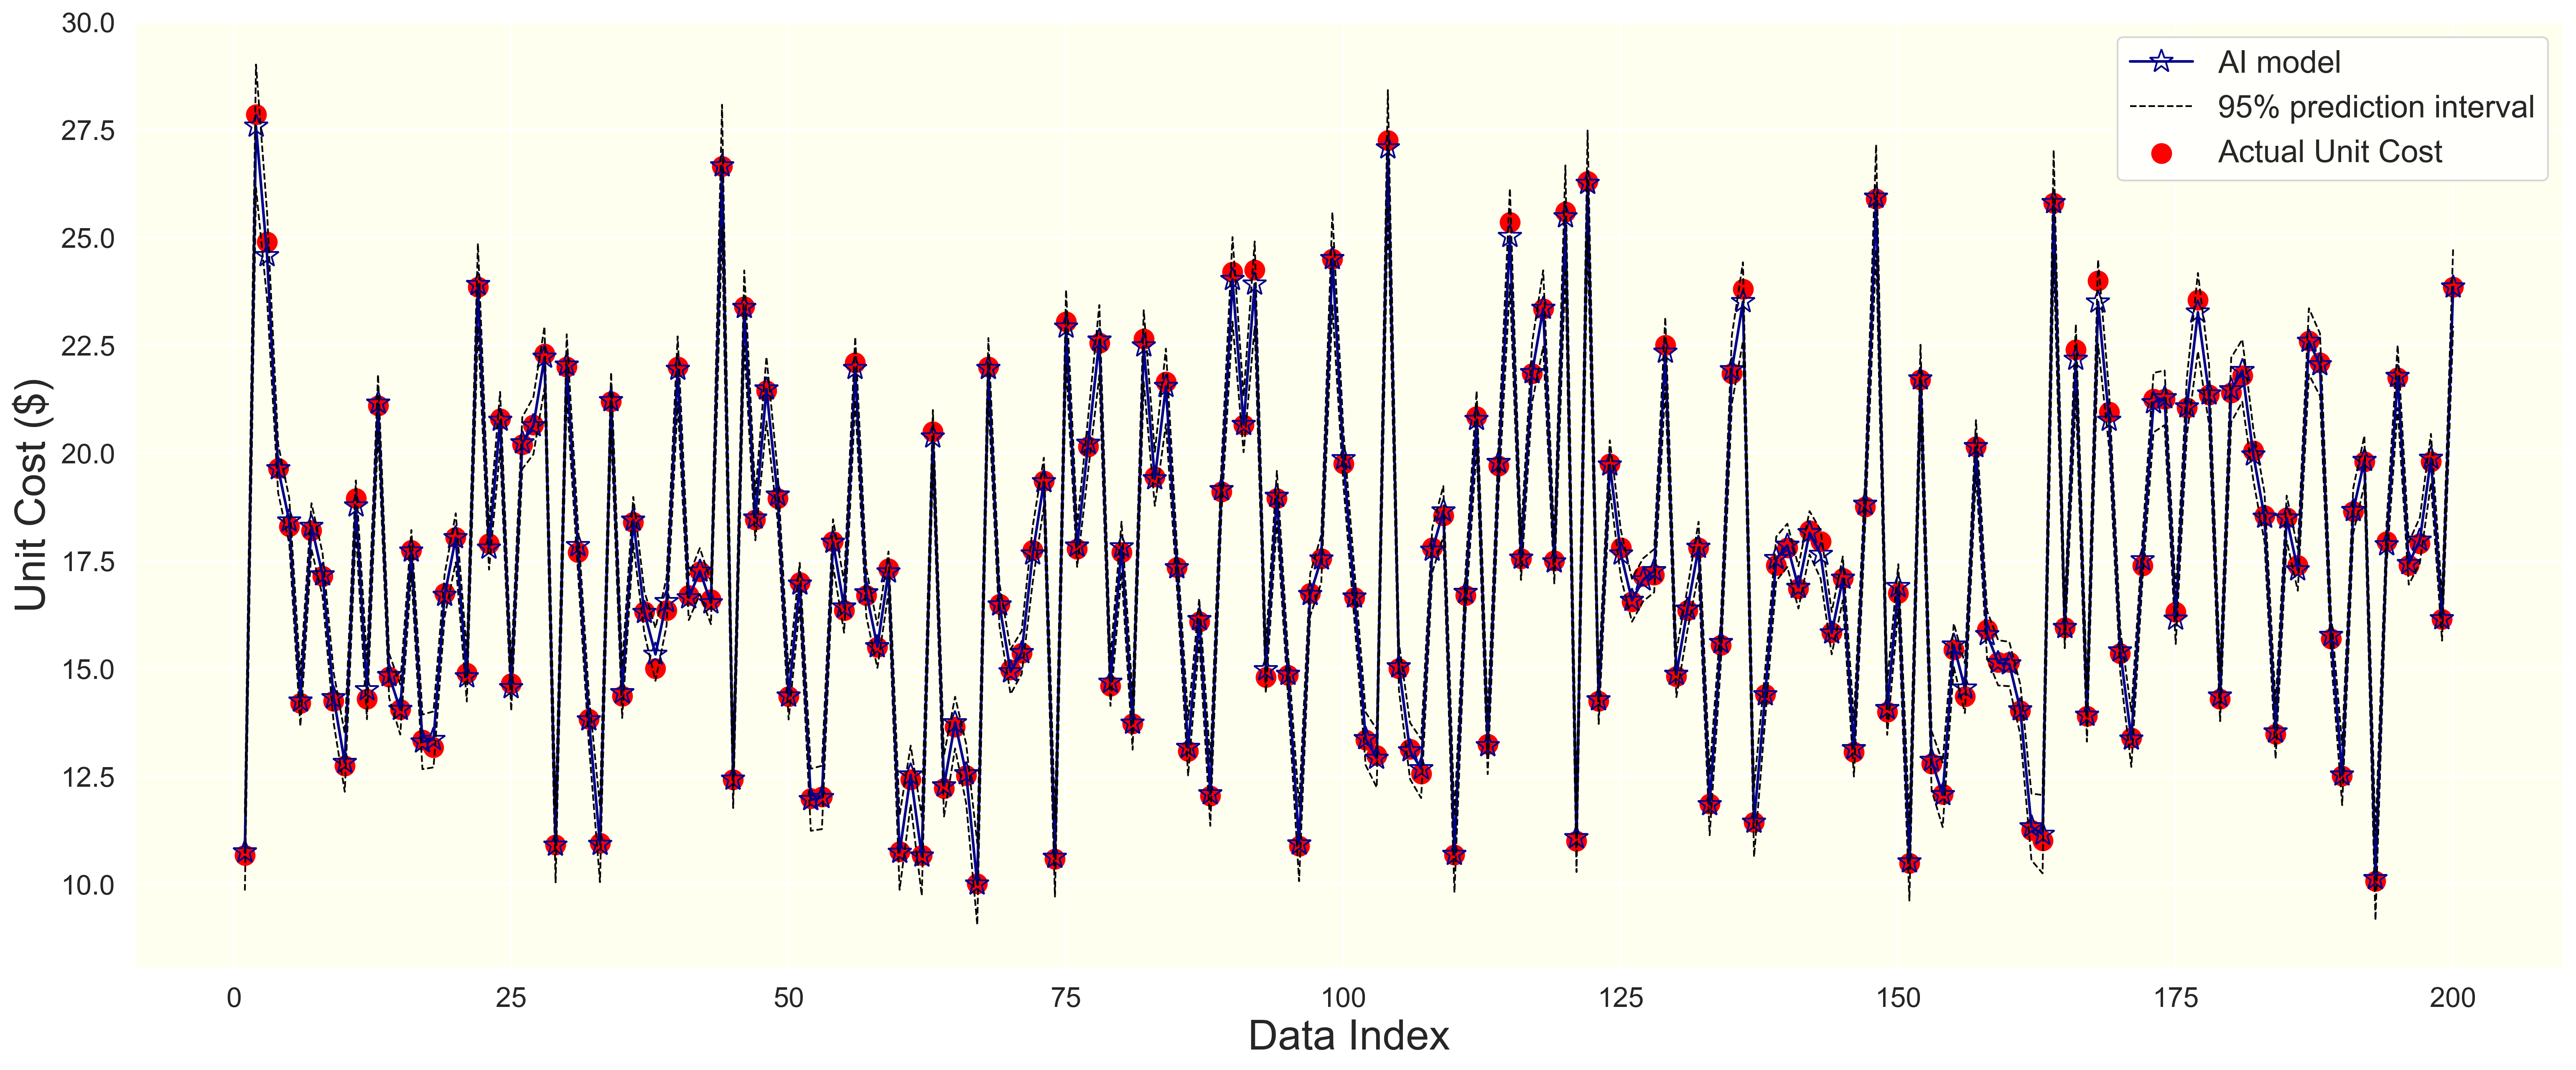

In [12]:
#----------------------------------------------------------------------------------
# Compare compressive strength measurements from AI method and Actual Measurements
#----------------------------------------------------------------------------------

leg_loc = 1
fig = plt.figure(figsize=(25,10),dpi=300)
ax = fig.add_subplot(1,1,1,facecolor='ivory')

ax.scatter(np.arange(1,len(y_test)+1,1),   y_test, marker = 'o', c = 'red', \
        s=120, label = 'Actual Unit Cost')
ax.plot(np.arange(1,len(y_test)+1,1),   Predicted_PET.loc,'-', marker = '*', color = 'darkblue', lw = 1.5,\
        mfc='none', markersize=14, label = 'AI model')
ax.plot(np.arange(1,len(y_test)+1,1),   Predicted_PET.loc - 1.96 * Predicted_PET.scale,'--', color = 'black', lw = 1,\
        mfc='none', label = '95% prediction interval')
ax.plot(np.arange(1,len(y_test)+1,1),   Predicted_PET.loc + 1.96 * Predicted_PET.scale,'--', color = 'black', lw = 1,\
        mfc='none')

ax.grid(True, which='major', axis='x' )
ax.grid(True, which='major', axis='y' )
ax.set_xlabel('Data Index', fontsize = 24)
ax.tick_params(axis = "x", labelsize = 16)
ax.xaxis.set_tick_params(pad=5)
ax.set_ylabel("Unit Cost ($)", fontsize = 24)
ax.tick_params(axis = "y", labelsize = 16)
ax.yaxis.set_tick_params(pad=5) # gap between ticks and axis
yoffset=0.05                    #gap between ticks and label
plt.legend(loc=leg_loc, prop={'size': 18}, facecolor='white')

plt.show()
fig.savefig('AI vs. Actual - NGBoost - 1Way.pdf', format='pdf', dpi=300)